
In this exercise we will implement a Natural Language Processing (NLP) system using binary logistic regression.

The data we will be working with comes from the [Yelp Dataset] (https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings. Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$



Implementing a function to trim out-of-vocabulary words from the reviews. Our function returns an nd array of the same dimension and dtype as the original loaded dataset.

In [ ]:
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

################################################################################
# We have provided you the functions for loading the tsv and txt files. Feel   #
# free to use them! No need to change them at all.                             #
################################################################################


def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map


def trim_reviews(path_to_dataset):
    dataset = load_tsv_dataset(path_to_dataset)
    word2vec_map = load_feature_dictionary("./data/word2vec.txt")

    # Iterate through the dataset, trim out-of-vocabulary words from the reviews
    trimmed_dataset = []
    for label, review in dataset:
        words = review.split()
        trimmed_review = ' '.join([word for word in words if word in word2vec_map])
        trimmed_dataset.append((label, trimmed_review))

    # Convert the trimmed dataset to an np.ndarray with the same dtype as the original dataset
    trimmed_dataset = np.array(trimmed_dataset, dtype=dataset.dtype)

    return trimmed_dataset

trim_train = trim_reviews("./data/train_small.tsv")
trim_test = trim_reviews("./data/test_small.tsv")

In [ ]:
print(trim_train)

[(1, 'i will never forget this single breakfast experience in madison it was awesome yes it is crowded and you have to sit with other groups at the large tables yes you have to pay cash yes it seems like you are eating breakfast in your grandmother s kitchen but seriously i like my grandmother s kitchen it is quite the experience and totally worth the perceived the coffee was fresh and dark the chocolate was to die for and the fruit covered french toast made from was sinful if i ever find myself in madison again i will definitely go out of my way to return to this little gem of a breakfast')
 (0, 'the search for decent chinese in madison continues the food at this place we ordered delivery is nothing worth waiting hours for egg rolls which contain nothing but lo they clearly do not understand how to work with nor do they get how to deliver quality food in a timely fashion the one plus was the were still just save your time and money and don t bother not even a good of can make their ho

Implement the embedding and store it to a `.tsv` file where the first column is the label and the rest are the features from the embedding. Round all numbers to 6 decimal places. `embedded_train_small.tsv` and `embedded_test_small.tsv` contain the expected output of your function.

In [ ]:
def embed_reviews(trimmed_dataset):

    word2vec_map = load_feature_dictionary("./data/word2vec.txt")
    embedded_dataset = []
    for label, review in trimmed_dataset:
        words = review.split()
        word_embeddings = [word2vec_map[word] for word in words if word in word2vec_map]
        if len(word_embeddings) > 0:
            avg_embedding = np.mean(word_embeddings, axis=0)
        else:
            avg_embedding = np.zeros(VECTOR_LEN)

        # Round the embeddings to 6 decimal places
        avg_embedding = np.round(avg_embedding, 6)
        embedded_dataset.append((label, avg_embedding))

    return embedded_dataset

def save_as_tsv(dataset, filename):
    with open(filename, 'w+', newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        for label, embedding in dataset:
            row = [label] + embedding.tolist()
            writer.writerow(row)
    return

embedded_train = embed_reviews(trim_train)
embedded_test = embed_reviews(trim_test)

save_as_tsv(embedded_train, "./data/output/embedded_train_small.tsv")
save_as_tsv(embedded_test, "./data/output/embedded_test_small.tsv")


In this part we'll be implementing Gradient Descent for binary Logistic Regression Classifier.


The expected `metrics.txt` from the dataset with `500` epochs and `0.01` learning rate is:

```
error(train): 0.000000
error(test): 0.625000
```

In [ ]:
import numpy as np

def load_tsv_dataset(file):
    return np.loadtxt(file, delimiter='\t', encoding='utf-8')


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def gd(theta, X, y, learning_rate):
    m = len(y)
    y_pred = sigmoid(X.dot(theta))
    gradient = (1 / m) * X.T.dot(y_pred - y)
    theta -= learning_rate * gradient
    return theta


def train(theta, X, y, num_epoch, learning_rate):
    for _ in range(num_epoch):
        theta = gd(theta, X, y, learning_rate)
    return theta


def predict(theta, X):
    # TODO: implement in vector form
    return sigmoid(X.dot(theta)) >= 0.5


def compute_error(y_pred, y):
    # TODO: implement in vector form
    return np.mean(y_pred != y)


def write_metrics(train_err, test_err, metrics_out):
    with open(metrics_out, 'w+') as f:
        w = "error(train): " + "{:.6f}".format(train_err) + "\n"
        w += "error(test): " + "{:.6f}".format(test_err) + "\n"
        f.write(w)
    return


def logistic_reg(formatted_train, formatted_test, metrics_out, num_epochs, learning_rate):
    train_data = load_tsv_dataset(formatted_train)
    test_data = load_tsv_dataset(formatted_test)

    # Extract and preprocess the input features and labels for training
    y = train_data[:, 0].astype(int)
    X = train_data[:, 1:]
    X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add a column of ones for the bias term

    # Initialize theta
    theta = np.zeros(X.shape[1])

    learned_theta = train(theta, X, y, num_epochs, learning_rate)
    train_pred = predict(learned_theta, X)
    train_err = compute_error(train_pred, y)

    # Extract and preprocess the input features and labels for testing
    y_test = test_data[:, 0].astype(int)
    X_test = test_data[:, 1:]
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))  # Add a column of ones for the bias term

    test_pred = predict(learned_theta, X_test)
    test_err = compute_error(test_pred, y_test)

    write_metrics(train_err, test_err, metrics_out)
    return


logistic_reg("./data/output/embedded_train_small.tsv", "./data/output/embedded_test_small.tsv", "./data/output/metrics.txt", 500, 0.01)

### Loading in the Data

For this exercise, we are interested in the two features `Texture Hardness` and `Texture Chewiness` and want to see if they are related. To do this, we will load in the data and create a scatter plot of the two features.

 Download the kaggle data from the link above and read in the `csv` files `cookie_train.csv` and `cookie_test.csv`

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

In [ ]:
#Code in this cell

cookie_train = pd.read_csv("./data/cookie_train.csv")
cookie_test = pd.read_csv("./data/cookie_test.csv")

In [ ]:
cookie_train.head()

,Id,Texture Hardness,Texture Chewiness,Texture Crispiness,Color L*,Color a*,Color b*,Taste Sweetness,Taste Saltiness,Taste Bitterness,Shape Diameter,Shape Thickness,Smell Intensity,Smell Complexity,Smell Specific Compound,Detected Chemical,Defective
0,59,120,0.05,1.2,80,20,40,2.0,0.5,0.10,6.0,0.5,1.0,10,5,Ethyl butyrate,0
1,60,150,0.08,1.4,85,23,43,3.0,0.6,0.20,5.5,0.6,0.9,12,6,Limonene,1
2,61,135,0.06,1.3,82,22,42,2.5,0.3,0.30,6.2,0.4,0.8,8,4,?-Pinene,0
3,62,100,0.02,1.0,75,18,38,1.5,0.2,0.05,7.0,0.7,0.7,7,3,Linalool,1
4,63,145,0.07,1.5,87,25,45,3.5,0.8,0.15,5.8,0.5,0.9,13,7,?-Caryophyllene,1


In [ ]:
cookie_test.head()

,Id,Texture Hardness,Texture Chewiness,Texture Crispiness,Color L*,Color a*,Color b*,Taste Sweetness,Taste Saltiness,Taste Bitterness,Shape Diameter,Shape Thickness,Smell Intensity,Smell Complexity,Smell Specific Compound,Detected Chemical,Defective
0,22,132,0.07,1.5,84,24,45,3.1,0.6,0.08,5.7,0.5,0.8,9,6,2-Heptanone,NaN
1,23,125,0.04,1.1,77,20,39,2.4,0.4,0.03,6.2,0.6,0.7,8,5,Butyric acid,NaN
2,24,138,0.08,1.8,87,26,47,4.0,0.7,0.15,5.4,0.4,1.0,11,8,Linalool,NaN
3,25,120,0.03,0.9,72,17,35,1.7,0.3,0.01,6.5,0.7,0.5,7,4,p-Cymene,NaN
4,26,147,0.10,2.0,92,31,51,4.5,0.9,0.25,5.1,0.3,1.1,13,9,Benzaldehyde,NaN


 Combining the training and testing data together into a single dataframe called `cookie_data` and plot the scatter plot for `Texture Chewiness` (our y or our response variable) and `Texture Hardness` (our x or our explanatory variable).

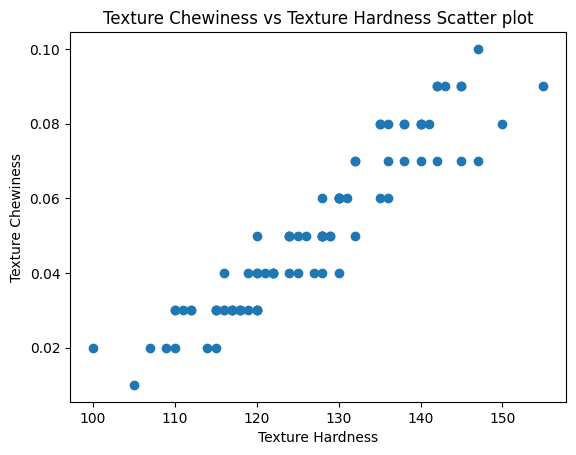

In [ ]:
#Code in this cell
cookie_data = pd.concat([cookie_train, cookie_test], ignore_index=True)


plt.scatter(cookie_data['Texture Hardness'], cookie_data['Texture Chewiness'])
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Texture Chewiness vs Texture Hardness Scatter plot')

plt.show()

### Checking If We Can Do Linear Regression

It is important to check all requirements/assumptions for linear regression are met before we do linear regression. One of the requirements is that the explanatory variable and response variable are linearly related, which we checked by noticing the scatter plot was linear. However, there is much more to check!

#### Checking for Normality
It is important to check that the response variable is normally distributed. This is important for hypothesis testing and relates to the idea of linear regression being an unbiased, minimum variance estimator (if you're interested in this, check out the course CAS MA 582).


Ploting an appropriate graph to determine if the response variable `Texture Chewiness` follows the normality assumption. State whether the normality assumption is met or not. If it is not met, state what can we do to fix this.

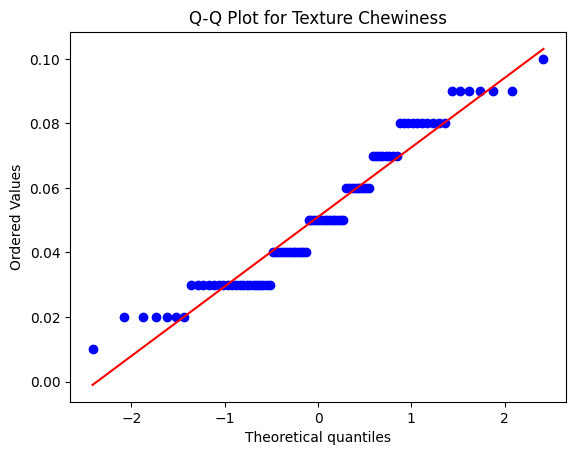

In [ ]:
fig, ax = plt.subplots()
stats.probplot(cookie_data['Texture Chewiness'], dist="norm", plot=ax)
ax.set_title("Q-Q Plot for Texture Chewiness")
plt.show()

/var/folders/hz/p6pbq8q57jz4g1876yfv757000cpxl/T/ipykernel_38565/4159270047.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cookie_data['Texture Chewiness'], shade=True)


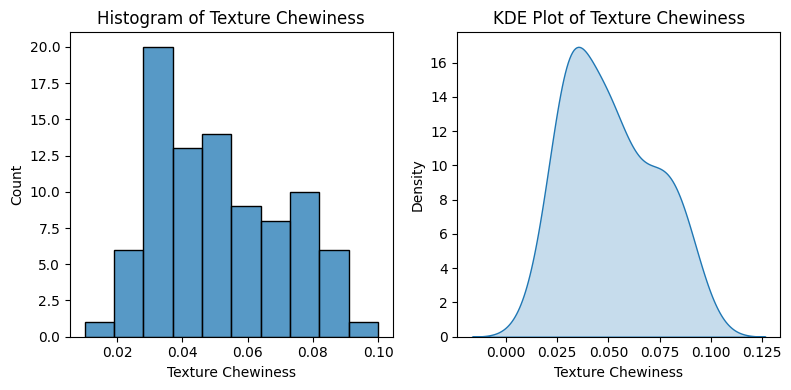

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))

#Plotting histogram
plt.subplot(1, 2, 1)
sns.histplot(cookie_data['Texture Chewiness'], kde=False, bins=10)
plt.title('Histogram of Texture Chewiness')
plt.xlabel('Texture Chewiness')

#Plotting KDE
plt.subplot(1, 2, 2)
sns.kdeplot(cookie_data['Texture Chewiness'], shade=True)
plt.title('KDE Plot of Texture Chewiness')
plt.xlabel('Texture Chewiness')

plt.tight_layout()
plt.show()

The above 3 plots show that the distribution of the response variable is not perfectly symmetric and bell-shaped. This indicates that the normality assumption might not be met.

To fix this, we can try to apply a transformation to the response variable (e.g., log, square root, or Box-Cox transformation) to make it more normally distributed. Then, we can recheck the normality assumption using the transformed data.

#### Checking for Homoscedasticity
It is important to check that the variance of the response variable is the same across all values of the explanatory variable. Otherwise, the confidence around a predicted value of the response variable will vary depending on the explanatory variable value.

 Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the homoscedasticity assumption. State whether the homoscedasticity assumption is met or not. If it is not met, state what can we do to fix this.

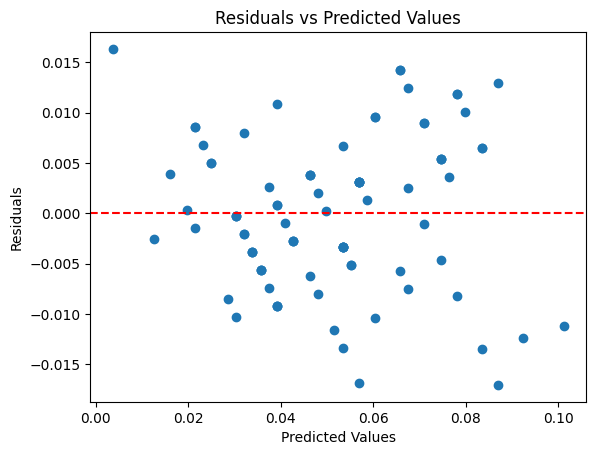

In [ ]:
#Plot in this cell

X = cookie_data[['Texture Hardness']]
y = cookie_data['Texture Chewiness']

model = LinearRegression()
model.fit(X, y)

#Calculate the predicted values and residuals
y_pred = model.predict(X)
residuals = y - y_pred

#Create the scatter plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.show()

The scatter plot shows that the residuals do not appear to have a constant variance across the range of predicted values, which indicates that the homoscedasticity assumption might not be met. To fix this issue, we can try transforming the response variable or the explanatory variable (e.g., log, square root, or Box-Cox transformation) to stabilize the variance. After applying the transformation, recheck the homoscedasticity assumption using the transformed data.

#### Checking for Independence
It is important to check that the explanatory variable and response variable are independent. Otherwise, the model isn't really best fit with a line. To do so, we will use the Durbin-Watson test.

 Using the Durbin-Watson test to determine if the explanatory variable and response variable are independent.

In [ ]:
dw_stat = durbin_watson(cookie_data['Texture Hardness'])

print("Durbin-Watson test statistic:", dw_stat)

if dw_stat < 1.5:
    print("The test indicates positive autocorrelation.")
    print("The independence assumption might not be met.")
elif dw_stat > 2.5:
    print("The test indicates negative autocorrelation.")
    print("The independence assumption might not be met.")
else:
    print("The test indicates no autocorrelation.")
    print("The independence assumption is met.")

Durbin-Watson test statistic: 0.02026783626470161
The test indicates positive autocorrelation.
The independence assumption might not be met.


Durbin-Watson test statistic is less than 0.05  so, the assumption is not met. We can fix it by using transformations

#### Adjusting the Model
If you think any of the assumptions are not met, then you should respectively fix the model.

 If we think atleast one of the assumptions were not met, then adjust the model how you described you would. Otherwise, proceed to the next step and in the cell below, write "No adjustments were made to the model". However, if you do adjust the model, then in the cell below, justify why your adjustments is appropriate (i.e. plot the new graphs and statistics found above). You may add as many cells as you like.

#### Fixing normal distribution of 'Texture Chewiness'

/var/folders/hz/p6pbq8q57jz4g1876yfv757000cpxl/T/ipykernel_38565/3832566516.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cookie_data['Texture Chewiness'], shade=True)


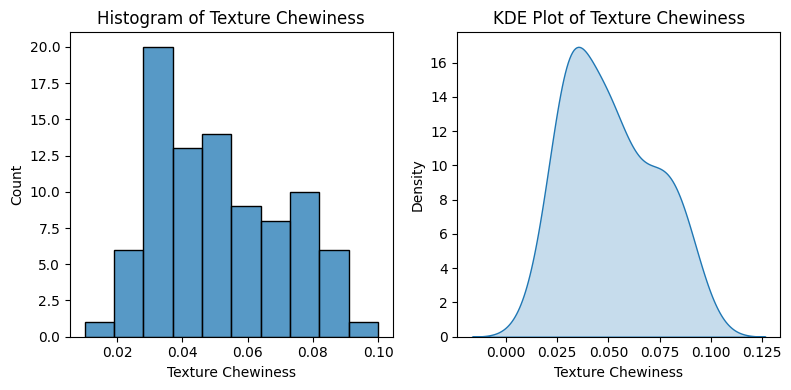

/var/folders/hz/p6pbq8q57jz4g1876yfv757000cpxl/T/ipykernel_38565/3832566516.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cookie_data['Texture Chewiness (log)'], shade=True)


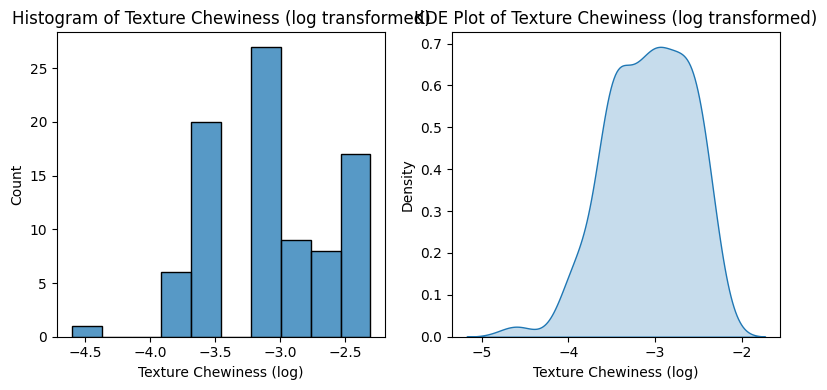

In [ ]:
# Original 'Texture Chewiness' without normally distributed

plt.figure(figsize=(8, 4))

#Plotting histogram
plt.subplot(1, 2, 1)
sns.histplot(cookie_data['Texture Chewiness'], kde=False, bins=10)
plt.title('Histogram of Texture Chewiness')
plt.xlabel('Texture Chewiness')

#Plotting KDE
plt.subplot(1, 2, 2)
sns.kdeplot(cookie_data['Texture Chewiness'], shade=True)
plt.title('KDE Plot of Texture Chewiness')
plt.xlabel('Texture Chewiness')

plt.tight_layout()
plt.show()

# Applying log transformation to make 'Texture Chewiness' normally distributed
cookie_data['Texture Chewiness (log)'] = np.log(cookie_data['Texture Chewiness'])

#Plot the histogram and KDE for the transformed data
plt.figure(figsize=(8, 4))

#Plotting histogram
plt.subplot(1, 2, 1)
sns.histplot(cookie_data['Texture Chewiness (log)'], kde=False, bins=10)
plt.title('Histogram of Texture Chewiness (log transformed)')
plt.xlabel('Texture Chewiness (log)')

#Plotting KDE
plt.subplot(1, 2, 2)
sns.kdeplot(cookie_data['Texture Chewiness (log)'], shade=True)
plt.title('KDE Plot of Texture Chewiness (log transformed)')
plt.xlabel('Texture Chewiness (log)')

plt.tight_layout()
plt.show()

The log-transformed response variable looks more symmetric and bell-shaped than the original data, indicating an improvement in meeting the normality assumption.

#### Now, checking Homoscedasticity of 'Texture Chewiness'

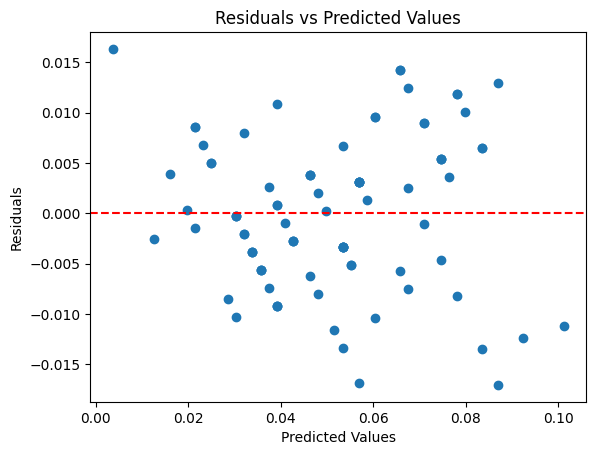

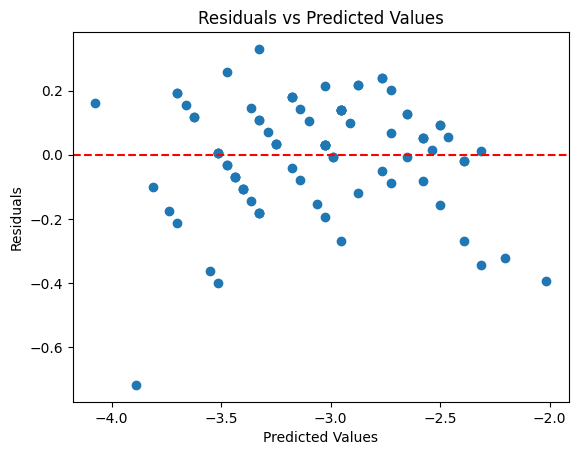

In [ ]:
#Original Plot
X = cookie_data[['Texture Hardness']]
y = cookie_data['Texture Chewiness']

model = LinearRegression()
model.fit(X, y)

#Calculate the predicted values and residuals
y_pred = model.predict(X)
residuals = y - y_pred

#Create the scatter plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.show()

# Log transformed Plot

X = cookie_data[['Texture Hardness']]
y_log  = cookie_data['Texture Chewiness (log)']

model = LinearRegression()
model.fit(X, y_log )

#Calculate the predicted values and residuals
y_pred = model.predict(X)
residuals = y_log  - y_pred

#Create the scatter plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.show()

The scatter plot of the residuals vs predicted values for the log-transformed model appears to have a more constant variance across the range of predicted values, which indicates an improvement in meeting the homoscedasticity assumption

### Hypothesis Testing
Now that we have a model that is appropriate, we can do hypothesis testing. We will be using the Linear Regression t-test to test if the explanatory variable is a significant predictor of the response variable.

Using the Linear Regression t-test to determine if the explanatory variable `Texture Hardness` is a significant predictor of the response variable `Texture Chewiness`. State whether if the explanatory variable is a significant predictor of the response variable or not using an alpha significance level of $\alpha = 0.05$, the null hypothesis $\beta_{hardness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$. If it is not, state what can we do to fix this.

In [ ]:
#Your code in this cell
#Add a constant to the explanatory variable
X = sm.add_constant(cookie_data[['Texture Hardness']])

#Fit the linear regression model using the log-transformed response variable
model_log = sm.OLS(y_log, X).fit()

#Print the summary table
print(model_log.summary())

                               OLS Regression Results                              
Dep. Variable:     Texture Chewiness (log)   R-squared:                       0.858
Model:                                 OLS   Adj. R-squared:                  0.856
Method:                      Least Squares   F-statistic:                     519.7
Date:                     Wed, 12 Apr 2023   Prob (F-statistic):           3.25e-38
Time:                             14:49:18   Log-Likelihood:                 28.684
No. Observations:                       88   AIC:                            -53.37
Df Residuals:                           86   BIC:                            -48.41
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

Based on the OLS Regression Results, the p-value (P>|t|) for the Texture Hardness variable is 0.000, which is less than the significance level (𝛼=0.05). Therefore, we can reject the null hypothesis (𝛽ℎ𝑎𝑟𝑑𝑛𝑒𝑠𝑠=0) and conclude that the explanatory variable Texture Hardness is a significant predictor of the response variable Texture Chewiness (log-transformed).

The R-squared value is 0.858, which indicates that 85.8% of the variability in the log-transformed response variable (Texture Chewiness) is explained by the explanatory variable (Texture Hardness).

### Adding a New Feature
Now that we have determined that the explanatory variable is a significant predictor of the response variable, you noticed the fit isn't 100% perfect still (e.g. your model is not capturing all the variation in the data). You think that there is another feature that can help improve the model. You think that the feature `Taste Sweetness` can help improve your model. You want to test if this is true. You may assume that all the assumptions are met for this new model to conduct linear regression.

Now that you have two features to predict your response variable, you will have to use multiple linear regression. Use the `statsmodels` library to do multiple linear regression. Then, determine if the explanatory variables `Texture Hardness` and `Taste Sweetness` are significant predictors of the response variable `Texture Chewiness` using an alpha significance level of $\alpha = 0.001$, the null hypothesis $\beta_{hardness} = 0$ and $\beta_{sweetness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$ and $\beta_{sweetness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

Moreover, justify whether the overall model is significant or not using the F-test with the same $\alpha$ given above. If it is not, state what can we do to fix this.

In [ ]:
#Your code in this cell
#Add Taste Sweetness to the explanatory variables
X_mult = cookie_data[['Texture Hardness', 'Taste Sweetness']]
X_mult = sm.add_constant(X_mult)

#Fit the multiple linear regression model using the log-transformed response variable
model_mult = sm.OLS(y_log, X_mult).fit()

#Print the summary table
print(model_mult.summary())

                               OLS Regression Results                              
Dep. Variable:     Texture Chewiness (log)   R-squared:                       0.883
Model:                                 OLS   Adj. R-squared:                  0.880
Method:                      Least Squares   F-statistic:                     321.2
Date:                     Wed, 12 Apr 2023   Prob (F-statistic):           2.37e-40
Time:                             14:49:18   Log-Likelihood:                 37.254
No. Observations:                       88   AIC:                            -68.51
Df Residuals:                           85   BIC:                            -61.08
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

Based on the OLS Regression Results, the p-values (P>|t|) for the Texture Hardness and Taste Sweetness variables are both 0.000, which are less than the significance level (𝛼=0.001). Therefore, we can reject the null hypotheses (𝛽ℎ𝑎𝑟𝑑𝑛𝑒𝑠𝑠=0 and 𝛽𝑠𝑤𝑒𝑒𝑡𝑛𝑒𝑠𝑠=0) and conclude that both explanatory variables (Texture Hardness and Taste Sweetness) are significant predictors of the response variable (log-transformed Texture Chewiness).

The R-squared value is 0.883, indicating that 88.3% of the variability in the log-transformed response variable (Texture Chewiness) is explained by the explanatory variables (Texture Hardness and Taste Sweetness). The model seems to be a better fit for the data compared to the simple linear regression model with only Texture Hardness as a predictor.

Regarding the overall model significance, the Prob (F-statistic) value is 2.37e-40, which is less than the significance level (𝛼=0.001). This means the overall model is significant.

### Interpretation
It is important to be able to interpret the results of the model. This is important because it allows us to understand the model and how it works. It also allows us to understand the relationship between the predictors and the response variable, and this applies to not just linear regression, but all learning models.

 Interpret the coefficients of the model. What do they mean? What do they represent? What do they tell us about the relationship between the predictors and the response variable? If your code output in part h does not provide these results, you are welcome to use any library here to do so.

In part h, we obtained the following coefficients for the multiple linear regression model:

Constant (intercept): -6.8521
Texture Hardness: 0.0266
Taste Sweetness: 0.1608
These coefficients can be interpreted as follows:

Constant (intercept): The constant, -6.8521, represents the expected value of the log-transformed Texture Chewiness when both Texture Hardness and Taste Sweetness are equal to 0. However, keep in mind that this interpretation might not make practical sense in real-world situations since the values of 0 for Texture Hardness and Taste Sweetness are likely outside the range of the data.

Texture Hardness: The coefficient of Texture Hardness, 0.0266, indicates that for every unit increase in Texture Hardness, the log-transformed Texture Chewiness is expected to increase by 0.0266 units, holding the Taste Sweetness constant. In other words, an increase in Texture Hardness leads to an increase in Texture Chewiness, indicating a positive relationship between Texture Hardness and Texture Chewiness. Keep in mind that this is on the log scale, so the actual relationship is multiplicative rather than additive in the original scale.

Taste Sweetness: The coefficient of Taste Sweetness, 0.1608, suggests that for every unit increase in Taste Sweetness, the log-transformed Texture Chewiness is expected to increase by 0.1608 units, holding the Texture Hardness constant. This implies that an increase in Taste Sweetness is also associated with an increase in Texture Chewiness, indicating a positive relationship between Taste Sweetness and Texture Chewiness. Again, this relationship is multiplicative in the original scale due to the log transformation.

In summary, the multiple linear regression model indicates that both Texture Hardness and Taste Sweetness have positive relationships with Texture Chewiness. As Texture Hardness and Taste Sweetness increase, the Texture Chewiness of the cookies is expected to increase as well, assuming all other factors are held constant.

### Using Taste Bitterness over Taste Sweetness
You think that the feature `Taste Bitterness` can help improve your model since `Taste Sweetness` wasn't it.

For this section, you will continue to use your fixed/adjusted features for `Texture Hardness` and `Texture Chewiness`.

Plot 2 scatter plots: `Taste Bitterness` vs your possibly adjusted `Texture Chewiness` and `Taste Bitterness` vs your possibly adjusted `Texture Hardness`. Given these plots, propose an appropriate model. Justify your answer by fitting it and seeing its accuracy (you can use any metric to prove so), showing appropriate models/graphs, and ensuring assumptions are satisfied (if any).

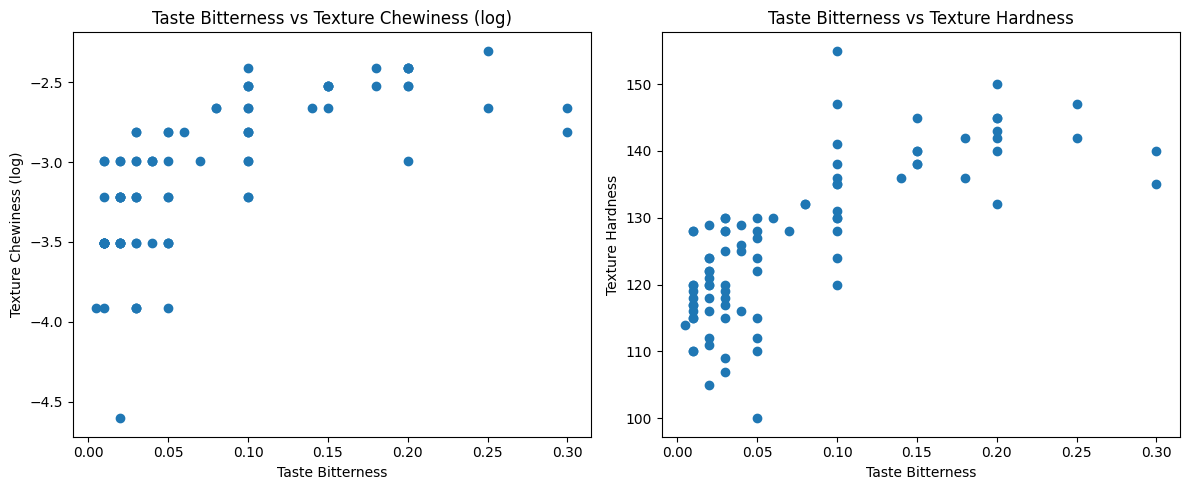

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(cookie_data['Taste Bitterness'], np.log(cookie_data['Texture Chewiness']))
plt.xlabel('Taste Bitterness')
plt.ylabel('Texture Chewiness (log)')
plt.title('Taste Bitterness vs Texture Chewiness (log)')

plt.subplot(1, 2, 2)
plt.scatter(cookie_data['Taste Bitterness'], cookie_data['Texture Hardness'])
plt.xlabel('Taste Bitterness')
plt.ylabel('Texture Hardness')
plt.title('Taste Bitterness vs Texture Hardness')

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

# Define the predictors and response variable
X = cookie_data[['Texture Hardness', 'Taste Bitterness']]
y = np.log(cookie_data['Texture Chewiness'])

# Add a constant term to the predictors
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     256.9
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           9.22e-37
Time:                        14:49:18   Log-Likelihood:                 28.695
No. Observations:                  88   AIC:                            -51.39
Df Residuals:                      85   BIC:                            -43.96
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7875      0.295  

Based on the OLS Regression Results, the R-squared value is 0.858, which means that the model explains 85.8% of the variance in the adjusted Texture Chewiness. This is a relatively high R-squared value, indicating that the model fits the data well.

However, when looking at the p-values for the coefficients, we can see that the p-value for Taste Bitterness is 0.884, which is much greater than the significance level of 0.05. This suggests that Taste Bitterness is not a statistically significant predictor of the adjusted Texture Chewiness.

The p-value for Texture Hardness, on the other hand, is very low (close to 0), indicating that it is a significant predictor of the adjusted Texture Chewiness.